<a href="https://colab.research.google.com/github/XindaLi304/gen_of_image/blob/main/GEN_of_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. autoregressive generation:  
 1.1 pixel rnn: predict the next pixel in raster scan  
 1.1.1 vanilla pixel rnn: one layer LSTM
    



Epoch [1/50], Train Loss: 2.8680
Validation Loss: 2.5727
Epoch [2/50], Train Loss: 2.5042
Validation Loss: 2.4594
Epoch [3/50], Train Loss: 2.4074
Validation Loss: 2.4453
Epoch [4/50], Train Loss: 2.3597
Validation Loss: 2.3410
Epoch [5/50], Train Loss: 2.3235
Validation Loss: 2.3192
Epoch [6/50], Train Loss: 2.2917
Validation Loss: 2.2912
Epoch [7/50], Train Loss: 2.3091
Validation Loss: 2.2776
Epoch [8/50], Train Loss: 2.2606
Validation Loss: 2.2559
Epoch [9/50], Train Loss: 2.7374
Validation Loss: 2.7422
Epoch [10/50], Train Loss: 2.7110
Validation Loss: 2.7002
Epoch [11/50], Train Loss: 2.6840
Validation Loss: 2.6800
Epoch [12/50], Train Loss: 2.6628
Validation Loss: 2.6641
Epoch [13/50], Train Loss: 2.6421
Validation Loss: 2.6280
Epoch [14/50], Train Loss: 2.6090
Validation Loss: 2.5970
Epoch [15/50], Train Loss: 2.5795
Validation Loss: 2.5663
Epoch [16/50], Train Loss: 2.5564
Validation Loss: 2.5477
Epoch [17/50], Train Loss: 2.5337
Validation Loss: 2.5359
Epoch [18/50], Train Lo

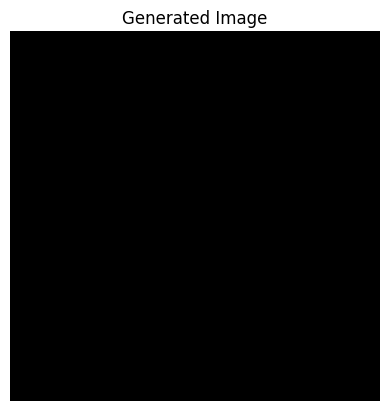

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 128
learning_rate = 0.01
num_epochs = 50
hidden_size = 128
sequence_length = 28 * 28  # Flattened image size
input_size = 1  # Each pixel is treated as a single input feature
num_classes = 256  # Grayscale intensity levels (0-255)

# Data Preparation
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# LSTM Model Definition
class PixelLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PixelLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(-1)  # Add feature dimension: (batch_size, seq_len, 1)
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initial hidden state
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initial cell state
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)  # Apply linear layer to LSTM outputs
        return out

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PixelLSTM(input_size=input_size, hidden_size=hidden_size, output_size=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training and Validation Loops
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        # Flatten images to (batch_size, 784)
        data = data.view(-1, 28 * 28).to(device)

        # Normalize pixel values to 0-255 as integers
        data = (data * 255).long()

        # Create inputs and targets
        inputs = data[:, :-1].float() / 255.0  # Convert inputs to float and normalize
        targets = data[:, 1:]  # Targets remain integers for classification

        # Zero out gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Reshape outputs and targets for cross-entropy loss
        outputs = outputs.view(-1, num_classes)  # (batch_size * seq_len, num_classes)
        targets = targets.reshape(-1) # (batch_size * seq_len)

        # Calculate loss
        loss = criterion(outputs, targets)
        train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss / len(train_loader):.4f}")

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            # Flatten and preprocess data
            data = data.view(-1, 28 * 28).to(device)
            data = (data * 255).long()

            inputs = data[:, :-1].float() / 255.0  # Convert inputs to float and normalize
            targets = data[:, 1:]  # Targets remain integers

            outputs = model(inputs)
            outputs = outputs.view(-1, num_classes)
            targets = targets.reshape(-1)
            print(outputs.shape)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    print(f"Validation Loss: {val_loss / len(test_loader):.4f}")

# Sample Generation
def generate_sample(model, device, seed_image=None):
    model.eval()
    with torch.no_grad():
        if seed_image is None:
            # Start with an empty canvas
            generated = torch.zeros((1, 28 * 28), device=device).long()
        else:
            # Use the provided seed
            generated = seed_image.view(1, 28 * 28).long()

        for i in range(1, 28 * 28):
            # Predict the next pixel based on current sequence
            inputs = generated[:, :i].float() / 255.0  # Normalize inputs
            output = model(inputs)
            output = output[:, -1, :]  # Get the last timestep
            predicted_pixel = torch.argmax(output, dim=-1)  # Choose the class with highest probability
            generated[0, i] = predicted_pixel

        return generated.view(28, 28).cpu().numpy()

# Generate a sample image
sample_image = generate_sample(model, device)

# Plot the generated image
plt.imshow(sample_image, cmap='gray')
plt.title("Generated Image")
plt.axis("off")
plt.show()


1.1.2 update:   
masked conv2d as embbeding layer  
onelayer rnn to model autoregressive dependency

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Masked Convolution Layer
class MaskedConv2d(nn.Conv2d):
    def __init__(self, *args, mask_type="A", **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        assert mask_type in ["A", "B"], "Mask type must be 'A' or 'B'"
        self.mask_type = mask_type
        self.register_buffer("mask", self.weight.data.clone())
        _, _, height, width = self.weight.size()
        self.mask.fill_(1)
        self.mask[:, :, height // 2, width // 2 + (1 if mask_type == "B" else 0):] = 0
        self.mask[:, :, height // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

# PixelRNN Model
class PixelRNNWithMasking(nn.Module):
    def __init__(self, input_channels=1, hidden_dim=64, output_classes=256):
        super(PixelRNNWithMasking, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_classes = output_classes

        self.conv1 = MaskedConv2d(input_channels, hidden_dim, kernel_size=7, padding=3, mask_type="A")
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_classes)

    def forward(self, x):
        batch_size, _, height, width = x.size()
        x = self.conv1(x)  # Shape: (batch_size, hidden_dim, height, width)
        x = x.permute(0, 2, 3, 1).contiguous()  # Shape: (batch_size, height, width, hidden_dim)
        x = x.view(batch_size, height * width, self.hidden_dim)  # Flatten for RNN
        x, _ = self.rnn(x)
        x = self.fc(x)  # Shape: (batch_size, height * width, output_classes)
        x = x.view(batch_size, height, width, self.output_classes)
        return x

# Training Function
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, _ in dataloader:
        images = images.to(device)
        targets = (images * 255).long().squeeze(1) # Scale pixel values to [0, 255] as targets
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.permute(0, 3, 1, 2), targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# Sampling Function (Image Generation)
def generate_images(model, device, image_size=(28, 28)):
    model.eval()
    with torch.no_grad():
        generated = torch.zeros((1, 1, *image_size), device=device)
        for i in range(image_size[0]):
            for j in range(image_size[1]):
                logits = model(generated)  # Forward pass
                probs = torch.softmax(logits[0, :, i, j], dim=0)
                pixel_value = torch.multinomial(probs, 1).float() / 255.0
                generated[0, 0, i, j] = pixel_value
    return generated[0, 0].cpu().numpy()

# Parameters
batch_size = 640
learning_rate = 0.01
epochs = 50
image_size = (28, 28)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation (FashionMNIST)
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model, Loss, Optimizer
model = PixelRNNWithMasking(input_channels=1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(epochs):
    loss = train(model, train_loader, optimizer, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

# Generate and Display Images
generated_image = generate_images(model, device, image_size)
plt.imshow(generated_image, cmap="gray")
plt.title("Generated Image")
plt.show()


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


1.1.2.1 show the per-pixel loss of samples from train set


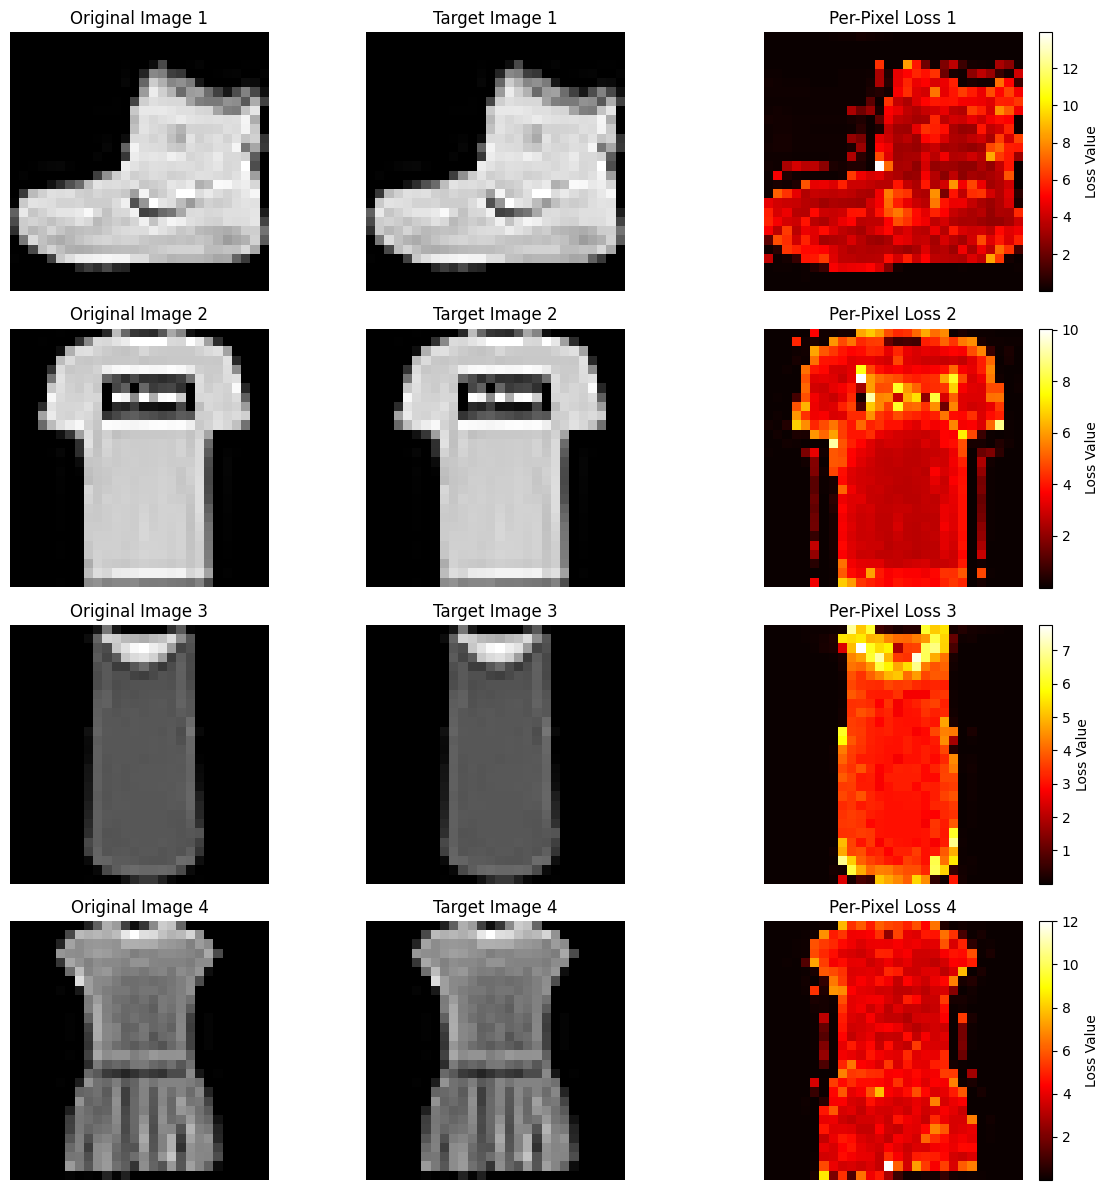

In [ ]:
# Function to calculate per-pixel training loss for a batch of samples
def calculate_training_pixel_loss_batch(model, images, targets, criterion, device):
    model.eval()
    with torch.no_grad():
        images = images.to(device)
        targets = targets.to(device)

        # Predict logits
        logits = model(images)  # Shape: [batch_size, num_classes, height, width]

        # Calculate per-pixel loss
        per_pixel_loss = F.cross_entropy(
            logits.permute(0, 3, 1, 2),  # [batch_size, num_classes, height, width]
            targets,  # [batch_size, height, width]
            reduction="none"  # No aggregation; loss for each pixel
        )
        return logits.cpu().numpy(), per_pixel_loss.cpu().numpy()

# Select multiple samples from the training dataset
num_samples = 4
indices = list(range(num_samples))  # Select the first `num_samples`
images, targets = zip(*[train_dataset[i] for i in indices])  # Get images and targets

# Prepare images and targets
images = torch.stack(images)  # Shape: [batch_size, channels, height, width]
targets = torch.stack([(img * 255).long().squeeze(0) for img in images])  # Scale to [0, 255]

# Calculate per-pixel loss for the batch
_, pixel_loss_maps = calculate_training_pixel_loss_batch(model, images, targets, criterion, device)

# Visualize the results
fig, axs = plt.subplots(num_samples, 3, figsize=(12, 3 * num_samples))

for i in range(num_samples):
    axs[i, 0].imshow(images[i, 0].cpu(), cmap="gray")
    axs[i, 0].set_title(f"Original Image {i+1}")
    axs[i, 0].axis('off')  # Hide axes for cleaner visualization

    axs[i, 1].imshow(targets[i].cpu(), cmap="gray")
    axs[i, 1].set_title(f"Target Image {i+1}")
    axs[i, 1].axis('off')  # Hide axes for cleaner visualization

    im = axs[i, 2].imshow(pixel_loss_maps[i], cmap="hot")
    axs[i, 2].set_title(f"Per-Pixel Loss {i+1}")
    axs[i, 2].axis('off')  # Hide axes for cleaner visualization

    # Add color bar for the per-pixel loss
    cbar = fig.colorbar(im, ax=axs[i, 2], orientation="vertical", fraction=0.046, pad=0.04)
    cbar.set_label("Loss Value")

plt.tight_layout()
plt.show()


1.1.3 update:   
multilayer lstms as model the autoregressive dependency   
conv2d in the final layer  
residual connection  
batchnorm  
MSE as loss


Epoch 1/50, Loss: 0.0149
Epoch 2/50, Loss: 0.0085
Epoch 3/50, Loss: 0.0076
Epoch 4/50, Loss: 0.0071
Epoch 5/50, Loss: 0.0069
Epoch 6/50, Loss: 0.0067
Epoch 7/50, Loss: 0.0066
Epoch 8/50, Loss: 0.0064
Epoch 9/50, Loss: 0.0063
Epoch 10/50, Loss: 0.0062
Epoch 11/50, Loss: 0.0061
Epoch 12/50, Loss: 0.0060
Epoch 13/50, Loss: 0.0060
Epoch 14/50, Loss: 0.0059
Epoch 15/50, Loss: 0.0059
Epoch 16/50, Loss: 0.0058
Epoch 17/50, Loss: 0.0058
Epoch 18/50, Loss: 0.0058
Epoch 19/50, Loss: 0.0057
Epoch 20/50, Loss: 0.0056
Epoch 21/50, Loss: 0.0056
Epoch 22/50, Loss: 0.0056
Epoch 23/50, Loss: 0.0056
Epoch 24/50, Loss: 0.0056
Epoch 25/50, Loss: 0.0055
Epoch 26/50, Loss: 0.0055
Epoch 27/50, Loss: 0.0055
Epoch 28/50, Loss: 0.0054
Epoch 29/50, Loss: 0.0054
Epoch 30/50, Loss: 0.0054
Epoch 31/50, Loss: 0.0054
Epoch 32/50, Loss: 0.0053
Epoch 33/50, Loss: 0.0053
Epoch 34/50, Loss: 0.0053
Epoch 35/50, Loss: 0.0053
Epoch 36/50, Loss: 0.0052
Epoch 37/50, Loss: 0.0053
Epoch 38/50, Loss: 0.0053
Epoch 39/50, Loss: 0.

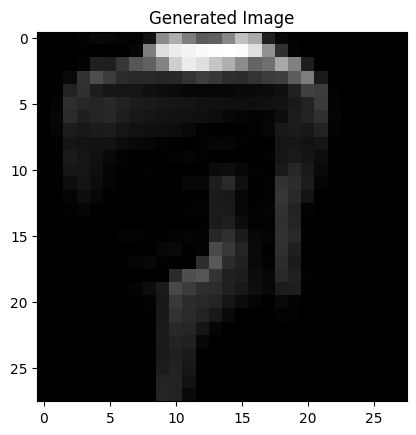

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Masked Convolution Layer
class MaskedConv2d(nn.Conv2d):
    def __init__(self, *args, mask_type="A", **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        assert mask_type in ["A", "B"], "Mask type must be 'A' or 'B'"
        self.mask_type = mask_type
        self.register_buffer("mask", self.weight.data.clone())
        _, _, height, width = self.weight.size()
        self.mask.fill_(1)
        self.mask[:, :, height // 2, width // 2 + (1 if mask_type == "B" else 0):] = 0
        self.mask[:, :, height // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

# PixelRNN Model with 7-layer LSTM, Residual Connections, and ReLU before Final Conv
class PixelRNNWithFinalReLU(nn.Module):
    def __init__(self, input_channels=1, hidden_dim=32, output_classes=1, lstm_layers=7):
        super(PixelRNNWithFinalReLU, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm_layers = lstm_layers

        # Masked convolution for initial feature extraction
        self.conv1 = MaskedConv2d(input_channels, hidden_dim, kernel_size=7, padding=3, mask_type="A")
        self.batch_norm_conv = nn.BatchNorm2d(hidden_dim)  # Batch normalization after masked convolution

        # Multiple LSTM layers with residual connections
        self.lstms = nn.ModuleList([nn.LSTM(hidden_dim, hidden_dim, batch_first=True) for _ in range(lstm_layers)])
        self.batch_norm_lstm = nn.ModuleList([nn.BatchNorm1d(hidden_dim) for _ in range(lstm_layers)])  # BatchNorm after LSTM

        # Conv2D with kernel (1,1) for final output
        self.final_conv = nn.Conv2d(hidden_dim, output_classes, kernel_size=1)

    def forward(self, x):
        batch_size, _, height, width = x.size()

        # Initial masked convolution and batch normalization
        x = self.conv1(x)  # Shape: (batch_size, hidden_dim, height, width)
        x = self.batch_norm_conv(x)
        #x = F.relu(x)  # Apply ReLU activation after the masked convolution and BatchNorm
        x = x.permute(0, 2, 3, 1).contiguous()  # Shape: (batch_size, height, width, hidden_dim)
        x = x.view(batch_size, height * width, self.hidden_dim)  # Flatten for LSTM

        # Pass through LSTM layers with residual connections and batch normalization
        for i, lstm in enumerate(self.lstms):
            residual = x
            x, _ = lstm(x)  # LSTM processing
            x = self.batch_norm_lstm[i](x.transpose(1, 2)).transpose(1, 2)  # Batch normalization
            x = x + residual  # Residual connection

        # Reshape back to (batch_size, hidden_dim, height, width)
        x = x.view(batch_size, height, width, self.hidden_dim).permute(0, 3, 1, 2)

        # Apply ReLU before final Conv2D
        x = F.relu(x)  # ReLU activation before final Conv2D

        # Final Conv2D with kernel (1,1) and Sigmoid activation
        x = self.final_conv(x)  # Shape: (batch_size, output_classes, height, width)
        x = torch.sigmoid(x)  # Sigmoid activation to produce output in [0, 1]
        return x

# Training Function
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, _ in dataloader:
        images = images.to(device)
        targets = images  # Targets are scaled between [0, 1], matching sigmoid output
        optimizer.zero_grad()
        outputs = model(images)  # Shape: (batch_size, 1, height, width)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# Sampling Function (Image Generation)
def generate_images(model, device, image_size=(28, 28)):
    model.eval()
    with torch.no_grad():
        generated = torch.zeros((1, 1, *image_size), device=device)
        for i in range(image_size[0]):
            for j in range(image_size[1]):
                logits = model(generated)  # Forward pass
                pixel_value = logits[0, 0, i, j].item()  # Direct sigmoid output in [0, 1]
                generated[0, 0, i, j] = pixel_value
    return generated[0, 0].cpu().numpy()

# Parameters
batch_size = 640
learning_rate = 0.001
epochs = 50
image_size = (28, 28)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation (FashionMNIST)
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model, Loss, Optimizer
model = PixelRNNWithFinalReLU(input_channels=1, hidden_dim=32, output_classes=1, lstm_layers=7).to(device)
criterion = nn.MSELoss()  # Mean Squared Error Loss for continuous outputs
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(epochs):
    loss = train(model, train_loader, optimizer, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

# Generate and Display Images
generated_image = generate_images(model, device, image_size)
plt.imshow(generated_image, cmap="gray")
plt.title("Generated Image")
plt.show()


1.1.4 update:
change loss into cross entropy loss from 1.1.3

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Masked Convolution Layer
class MaskedConv2d(nn.Conv2d):
    def __init__(self, *args, mask_type="A", **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        assert mask_type in ["A", "B"], "Mask type must be 'A' or 'B'"
        self.mask_type = mask_type
        self.register_buffer("mask", self.weight.data.clone())
        _, _, height, width = self.weight.size()
        self.mask.fill_(1)
        self.mask[:, :, height // 2, width // 2 + (1 if mask_type == "B" else 0):] = 0
        self.mask[:, :, height // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

# PixelRNN Model with 7-layer LSTM, Residual Connections, and ReLU before Final Conv
class PixelRNNWithFinalReLU(nn.Module):
    def __init__(self, input_channels=1, hidden_dim=32, output_classes=256, lstm_layers=7):
        super(PixelRNNWithFinalReLU, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm_layers = lstm_layers

        # Masked convolution for initial feature extraction
        self.conv1 = MaskedConv2d(input_channels, hidden_dim, kernel_size=7, padding=3, mask_type="A")
        self.batch_norm_conv = nn.BatchNorm2d(hidden_dim)  # Batch normalization after masked convolution

        # Multiple LSTM layers with residual connections
        self.lstms = nn.ModuleList([nn.LSTM(hidden_dim, hidden_dim, batch_first=True) for _ in range(lstm_layers)])
        self.batch_norm_lstm = nn.ModuleList([nn.BatchNorm1d(hidden_dim) for _ in range(lstm_layers)])  # BatchNorm after LSTM

        # Conv2D with kernel (1,1) for final output
        self.final_conv = nn.Conv2d(hidden_dim, output_classes, kernel_size=1)

    def forward(self, x):
        batch_size, _, height, width = x.size()

        # Initial masked convolution and batch normalization
        x = self.conv1(x)  # Shape: (batch_size, hidden_dim, height, width)
        x = self.batch_norm_conv(x)
        x = x.permute(0, 2, 3, 1).contiguous()  # Shape: (batch_size, height, width, hidden_dim)
        x = x.view(batch_size, height * width, self.hidden_dim)  # Flatten for LSTM

        # Pass through LSTM layers with residual connections and batch normalization
        for i, lstm in enumerate(self.lstms):
            residual = x
            x, _ = lstm(x)  # LSTM processing
            x = self.batch_norm_lstm[i](x.transpose(1, 2)).transpose(1, 2)  # Batch normalization
            x = x + residual  # Residual connection

        # Reshape back to (batch_size, hidden_dim, height, width)
        x = x.view(batch_size, height, width, self.hidden_dim).permute(0, 3, 1, 2)

        # Apply ReLU before final Conv2D
        x = F.relu(x)  # ReLU activation before final Conv2D

        # Final Conv2D with kernel (1,1) for class logits
        x = self.final_conv(x)  # Shape: (batch_size, 256, height, width)
        return x

# Training Function
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, _ in dataloader:
        images = images.to(device)
        targets = (images * 255).long().squeeze(1)  # Scale to [0, 255] and remove channel dimension
        optimizer.zero_grad()
        outputs = model(images)  # Shape: (batch_size, 256, height, width)
        loss = criterion(outputs, targets)  # CrossEntropyLoss expects logits and integer targets
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# Sampling Function (Image Generation)
def generate_images(model, device, image_size=(28, 28), temperature=1.0):
    model.eval()
    with torch.no_grad():
        generated = torch.zeros((1, 1, *image_size), device=device)
        for i in range(image_size[0]):
            for j in range(image_size[1]):
                logits = model(generated)  # Forward pass
                logits = logits[0, :, i, j] / temperature  # Logits for the pixel
                probs = F.softmax(logits, dim=0)  # Convert logits to probabilities
                pixel_value = torch.multinomial(probs, 1).item()  # Sample a pixel value
                generated[0, 0, i, j] = pixel_value / 255.0  # Normalize to [0, 1]
    return generated[0, 0].cpu().numpy()

# Parameters
batch_size = 640
learning_rate = 0.001
epochs = 50
image_size = (28, 28)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation (FashionMNIST)
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model, Loss, Optimizer
model = PixelRNNWithFinalReLU(input_channels=1, hidden_dim=32, output_classes=256, lstm_layers=7).to(device)
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss for 256 classes
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(epochs):
    loss = train(model, train_loader, optimizer, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

# Generate and Display Images
generated_image = generate_images(model, device, image_size)
plt.imshow(generated_image, cmap="gray", vmin=0, vmax=1)
plt.title("Generated Image")
plt.show()


1.2 pixeltransformer  
tranformer to model autoregressive dependency  
cross entropy as loss  



In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
#torch.cuda.empty_cache()
# Generate causal mask for the Transformer
def generate_causal_mask(seq_len):
    mask = torch.tril(torch.ones(seq_len, seq_len))

    return mask  # Shape: (seq_len, seq_len)

# Positional Encoding for Transformers
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, seq_len):
        super(PositionalEncoding, self).__init__()
        self.positional_encoding = nn.Parameter(torch.randn(1, seq_len, embed_dim))

    def forward(self, x):
        return x + self.positional_encoding

# Transformer-based PixelRNN
class PixelTransformer(nn.Module):
    def __init__(self, input_channels=1, embed_dim=32, num_layers=5, output_classes=256, img_size=(28, 28)):
        super(PixelTransformer, self).__init__()
        self.embed_dim = embed_dim
        self.seq_len = img_size[0] * img_size[1]  # Total number of pixels

        # Embedding layer to project input to embedding space
        self.embedding = nn.Conv2d(input_channels, embed_dim, kernel_size=1)

        # Positional encoding for raster-scan order
        self.positional_encoding = PositionalEncoding(embed_dim, self.seq_len)

        # Transformer encoder layers with dropout for regularization
        self.transformer = nn.Transformer(
            d_model=embed_dim, nhead=4, num_encoder_layers=num_layers, dropout=0.1, batch_first=True
        )

        # Output projection layer
        self.final_conv = nn.Conv2d(embed_dim, output_classes, kernel_size=1)


    def forward(self, x):
        batch_size, _, height, width = x.size()

        # Embed input and flatten to (batch_size, seq_len, embed_dim)
        x = self.embedding(x).permute(0, 2, 3, 1).contiguous()
        x = x.view(batch_size, self.seq_len, self.embed_dim)

        # Add positional encoding
        x = self.positional_encoding(x)

        # Generate causal mask
        causal_mask = generate_causal_mask(self.seq_len).to(x.device)

        # Apply transformer
        x = self.transformer(x, x, src_mask=causal_mask)

        # Reshape back to (batch_size, embed_dim, height, width)
        x = x.view(batch_size, height, width, self.embed_dim).permute(0, 3, 1, 2)

        # Final Conv2D (Logits for 256 classes)
        x = self.final_conv(x)  # Shape: (batch_size, 256, height, width)
        x = x.reshape(batch_size, height, width, 256)
        return x

# Training Function
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, _ in dataloader:
        images = images.to(device)

        targets = (images * 255).long().squeeze(1)

        optimizer.zero_grad()
        outputs = model(images)  # Shape: (batch_size, height, width,256)
        loss = criterion(outputs.permute(0,3,1,2), targets)  # CrossEntropyLoss expects logits and integer targets
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)



# Parameters
batch_size = 64*4
learning_rate = 0.05
epochs = 50
image_size = (28, 28)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation (FashionMNIST)
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model, Loss, and Optimizer
model = PixelTransformer(input_channels=1, embed_dim=32, num_layers=1, output_classes=256, img_size=image_size).to(device)
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss for 256 classes
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(epochs):
    loss = train(model, train_loader, optimizer, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")




100%|██████████| 26.4M/26.4M [00:02<00:00, 9.26MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 173kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.07MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 8.29MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Epoch 1/50, Loss: 5.4576
Epoch 2/50, Loss: 5.4535
Epoch 3/50, Loss: 5.4534
Epoch 4/50, Loss: 5.4533
Epoch 5/50, Loss: 5.4533
Epoch 6/50, Loss: 5.4532
Epoch 7/50, Loss: 5.4532
Epoch 8/50, Loss: 5.4533
Epoch 9/50, Loss: 5.4533
Epoch 10/50, Loss: 5.4533
Epoch 11/50, Loss: 5.4534
Epoch 12/50, Loss: 5.4536
Epoch 13/50, Loss: 5.4538
Epoch 14/50, Loss: 5.4543
Epoch 15/50, Loss: 5.4551
Epoch 16/50, Loss: 5.4563
Epoch 17/50, Loss: 5.4582
Epoch 18/50, Loss: 5.4607
Epoch 19/50, Loss: 5.4633
Epoch 20/50, Loss: 5.4663
Epoch 21/50, Loss: 5.4702
Epoch 22/50, Loss: 5.4728
Epoch 23/50, Loss: 5.4775
Epoch 24/50, Loss: 5.4799
Epoch 25/50, Loss: 5.4851
Epoch 26/50, Loss: 5.4863
Epoch 27/50, Loss: 5.4890
Epoch 28/50, Loss: 5.4917
Epoch 29/50, Loss: 5.4953
Epoch 30/50, Loss: 5.4986
Epoch 31/50, Loss: 5.5021
Epoch 32/50, Loss: 5.5061
Epoch 33/50, Loss: 5.5072
Epoch 34/50, Loss: 5.5107
Epoch 35/50, Loss: 5.5143
Epoch 36/5

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


1.2.1 param check

In [ ]:
import torch

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params


total, trainable = count_parameters(model)
print(f"Total parameters: {total}")
print(f"Trainable parameters: {trainable}")


2. VAE based:
2.1 cross entropy as loss

In [ ]:
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image

# -------------------------
# Define the VAE (Same as before)
# -------------------------
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, 512)
        self.fc3 = nn.Linear(512, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    # Using Binary Cross Entropy loss for reconstruction:
    # recon_x and x are both in [0,1], suitable for BCE
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

# -------------------------
# Hyperparameters
# -------------------------
batch_size = 128
epochs = 5   # shortened for demonstration
learning_rate = 1e-3
latent_dim = 20
input_dim = 28*28

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Load the Fashion-MNIST dataset
# -------------------------
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# -------------------------
# Instantiate model and optimizer
# -------------------------
model = VAE(input_dim=input_dim, latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# -------------------------
# Training loop
# -------------------------
model.train()
for epoch in range(epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, input_dim).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_train_loss:.4f}")

# -------------------------
# Generate Images
# -------------------------
model.eval()
os.makedirs("generated_images_for_eval", exist_ok=True)
num_images = 1000
num_batches = num_images // batch_size

with torch.no_grad():
    for i in range(num_batches):
        z = torch.randn(batch_size, latent_dim).to(device)
        samples = model.decode(z).cpu()
        samples = samples.view(batch_size, 1, 28, 28)
        for j in range(batch_size):
            img = transforms.ToPILImage()(samples[j])
            img.save(f"generated_images_for_eval/img_{i*batch_size+j:05d}.png")

# -------------------------
# Save Real Test Images
# -------------------------
os.makedirs("real_images_for_eval", exist_ok=True)
for i, (img, label) in enumerate(test_dataset):
    img = transforms.ToPILImage()(img)
    img.save(f"real_images_for_eval/img_{i:05d}.png")

# -------------------------
# Compute FID
# -------------------------
# Requires pytorch-fid: pip install pytorch-fid
from pytorch_fid import fid_score
fid_value = fid_score.calculate_fid_given_paths(['real_images_for_eval', 'generated_images_for_eval'],
                                                batch_size=50,
                                                device=device,
                                                dims=2048)
print("FID:", fid_value)

# -------------------------
# Compute Inception Score (IS)
# -------------------------
from torchvision.models import inception_v3

class ImageFolderDataset(Dataset):
    def __init__(self, folder):
        self.files = sorted(glob.glob(folder + "/*.png"))
        self.transform = transforms.Compose([
            transforms.Resize((299, 299)),  # Inception expects 299x299
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        img = Image.open(img_path).convert('RGB')
        return self.transform(img)

def inception_score(img_dataset, device='cpu', batch_size=64, splits=10):
    loader = DataLoader(img_dataset, batch_size=batch_size)
    inception = inception_v3(pretrained=True, transform_input=False).to(device)
    inception.eval()

    preds = []
    with torch.no_grad():
        for img_batch in loader:
            img_batch = img_batch.to(device)
            pred = inception(img_batch)
            preds.append(F.softmax(pred, dim=1).cpu())
    preds = torch.cat(preds, dim=0)

    # Compute IS
    split_size = preds.size(0) // splits
    scores = []
    for i in range(splits):
        part = preds[i*split_size:(i+1)*split_size, :]
        p_y = part.mean(dim=0, keepdim=True)
        kl_div = part * (part.log() - p_y.log())
        kl_div = kl_div.sum(dim=1).mean().exp()
        scores.append(kl_div.item())
    return sum(scores)/len(scores)

generated_dataset = ImageFolderDataset("generated_images_for_eval")
is_score = inception_score(generated_dataset, device=device)
print("Inception Score:", is_score)


Epoch [1/5], Loss: 283.6587
Epoch [2/5], Loss: 254.7806
Epoch [3/5], Loss: 249.3712
Epoch [4/5], Loss: 246.7964
Epoch [5/5], Loss: 245.3519


100%|██████████| 18/18 [00:00<00:00, 33.52it/s]


FID: 119.75806791257861
Inception Score: 2.872058701515198


3.2 mse as loss

In [ ]:
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import subprocess

# -------------------------
# Define the VAE
# -------------------------
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, 512)
        self.fc3 = nn.Linear(512, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    # Using MSE as requested
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

# -------------------------
# Hyperparameters
# -------------------------
batch_size = 128
epochs = 5  # shorten for demonstration
learning_rate = 1e-3
latent_dim = 20
input_dim = 28*28

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Load the Fashion-MNIST dataset
# -------------------------
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# -------------------------
# Instantiate model and optimizer
# -------------------------
model = VAE(input_dim=input_dim, latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
from torchvision import transforms

# Create a ToPILImage transform
to_pil = transforms.ToPILImage()

# -------------------------
# Training loop
# -------------------------
model.train()
for epoch in range(epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, input_dim).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_train_loss:.4f}")

# -------------------------
# Generate Images
# -------------------------
model.eval()
os.makedirs("generated_images_for_eval", exist_ok=True)
num_images = 1000
num_batches = num_images // batch_size

with torch.no_grad():
    for i in range(num_batches):
        z = torch.randn(batch_size, latent_dim).to(device)
        samples = model.decode(z).cpu()
        samples = samples.view(batch_size, 1, 28, 28)
        for j in range(batch_size):
            img = transforms.ToPILImage()(samples[j])
            img.save(f"generated_images_for_eval/img_{i*batch_size+j:05d}.png")


# -------------------------
# Save Real Test Images
# -------------------------
os.makedirs("real_images_for_eval", exist_ok=True)
for i, (img, label) in enumerate(test_dataset):
    # 'img' is a tensor here, so convert it to a PIL image
    img_pil = to_pil(img)
    img_pil.save(f"real_images_for_eval/img_{i:05d}.png")

# -------------------------
# Compute FID
# -------------------------
# FID requires pytorch-fid
# Install: pip install pytorch-fid
from pytorch_fid import fid_score
fid_value = fid_score.calculate_fid_given_paths(['real_images_for_eval', 'generated_images_for_eval'],
                                                batch_size=50,
                                                device=device,
                                                dims=2048)
print("FID:", fid_value)

# -------------------------
# Compute Inception Score (IS)
# -------------------------
# Note: Inception Score may not be meaningful for Fashion-MNIST.
from torchvision.models import inception_v3

class ImageFolderDataset(Dataset):
    def __init__(self, folder):
        self.files = sorted(glob.glob(folder + "/*.png"))
        self.transform = transforms.Compose([
            transforms.Resize((299, 299)),  # Inception expects 299x299
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # normalize for Inception
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        img = Image.open(img_path).convert('RGB')
        return self.transform(img)

def inception_score(img_dataset, device='cpu', batch_size=64, splits=10):
    loader = DataLoader(img_dataset, batch_size=batch_size)
    inception = inception_v3(pretrained=True, transform_input=False).to(device)
    inception.eval()

    preds = []
    with torch.no_grad():
        for img_batch in loader:
            img_batch = img_batch.to(device)
            pred = inception(img_batch)
            preds.append(F.softmax(pred, dim=1).cpu())
    preds = torch.cat(preds, dim=0)

    # Compute IS
    split_size = preds.size(0) // splits
    scores = []
    for i in range(splits):
        part = preds[i*split_size:(i+1)*split_size, :]
        p_y = part.mean(dim=0, keepdim=True)
        kl_div = part * (part.log() - p_y.log())
        kl_div = kl_div.sum(dim=1).mean().exp()
        scores.append(kl_div.item())
    return sum(scores)/len(scores)

generated_dataset = ImageFolderDataset("generated_images_for_eval")
is_score = inception_score(generated_dataset, device=device)
print("Inception Score:", is_score)


Epoch [1/5], Loss: 38.4818
Epoch [2/5], Loss: 28.8532
Epoch [3/5], Loss: 27.4405
Epoch [4/5], Loss: 26.7103
Epoch [5/5], Loss: 26.2390


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 340MB/s]
100%|██████████| 18/18 [00:00<00:00, 31.62it/s]


FID: 124.78139858835527


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 151MB/s]


Inception Score: 2.8809734106063845


3.3 conditional vae   
3.3.1 label induced at latent layer   
induce label at latent layer which means encoding process will not know the label information.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image

# -------------------------
# Define the Partially Conditional VAE
# (Conditioning only at the decoder stage)
# -------------------------
class CVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_classes, label_embed_dim=10):
        super(CVAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.label_embed_dim = label_embed_dim

        # Encoder (no label included)
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)

        # Label embedding for decoder
        self.label_emb = nn.Linear(num_classes, label_embed_dim)

        # Decoder (takes z + y_embed)
        self.fc2 = nn.Linear(latent_dim + label_embed_dim, 512)
        self.fc3 = nn.Linear(512, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        y_embed = F.relu(self.label_emb(y))
        dec_input = torch.cat([z, y_embed], dim=1)
        h = F.relu(self.fc2(dec_input))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x, y):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, y), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss


# -------------------------
# Hyperparameters
# -------------------------
batch_size = 128
epochs = 50   # shortened for demonstration
learning_rate = 1e-3
latent_dim = 20
input_dim = 28*28
num_classes = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Load the Fashion-MNIST dataset
# -------------------------
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

def one_hot(labels, num_classes=10):
    return F.one_hot(labels, num_classes=num_classes).float()

# -------------------------
# Instantiate the model and optimizer
# -------------------------
model = CVAE(input_dim=input_dim, latent_dim=latent_dim, num_classes=num_classes, label_embed_dim=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# -------------------------
# Training loop
# -------------------------
model.train()
for epoch in range(epochs):
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.view(-1, input_dim).to(device)
        labels_oh = one_hot(labels.to(device), num_classes)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data, labels_oh)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_train_loss:.4f}")

model.eval()

# Directory for generated images
os.makedirs("conditional_generated_images_on_request", exist_ok=True)

def generate_samples_for_class(class_label, num_samples=10):
    """
    Generate 'num_samples' images conditioned on the given 'class_label'.
    class_label should be an integer between 0 and 9 for Fashion-MNIST.
    """
    with torch.no_grad():
        # Sample latent vectors
        z = torch.randn(num_samples, latent_dim).to(device)
        # Create one-hot encoding for the class
        y_cond = torch.zeros(num_samples, num_classes, device=device)
        y_cond[:, class_label] = 1.0

        samples = model.decode(z, y_cond).cpu()  # shape: (num_samples, input_dim)
        samples = samples.view(num_samples, 1, 28, 28)

        # Save the generated samples
        for i in range(num_samples):
            img = transforms.ToPILImage()(samples[i])
            img.save(f"conditional_generated_images_on_request/class_{class_label}_img_{i}.png")
    print(f"Saved {num_samples} images for class {class_label} in 'conditional_generated_images_on_request'.")

# Example Usage:
# Generate 10 samples of class 3
generate_samples_for_class(class_label=3, num_samples=10)


Epoch [1/50], Loss: 280.9567
Epoch [2/50], Loss: 252.7247
Epoch [3/50], Loss: 247.5766
Epoch [4/50], Loss: 244.8998
Epoch [5/50], Loss: 243.1747
Epoch [6/50], Loss: 242.0338
Epoch [7/50], Loss: 241.1820
Epoch [8/50], Loss: 240.4977
Epoch [9/50], Loss: 239.9551
Epoch [10/50], Loss: 239.4858
Epoch [11/50], Loss: 239.1358
Epoch [12/50], Loss: 238.7855
Epoch [13/50], Loss: 238.4424
Epoch [14/50], Loss: 238.2060
Epoch [15/50], Loss: 238.0158
Epoch [16/50], Loss: 237.7485
Epoch [17/50], Loss: 237.5817
Epoch [18/50], Loss: 237.3896
Epoch [19/50], Loss: 237.2298
Epoch [20/50], Loss: 237.1097
Epoch [21/50], Loss: 237.0194
Epoch [22/50], Loss: 236.8453
Epoch [23/50], Loss: 236.7502
Epoch [24/50], Loss: 236.6344
Epoch [25/50], Loss: 236.6293
Epoch [26/50], Loss: 236.4783
Epoch [27/50], Loss: 236.3985
Epoch [28/50], Loss: 236.3031
Epoch [29/50], Loss: 236.2348
Epoch [30/50], Loss: 236.1947
Epoch [31/50], Loss: 236.0733
Epoch [32/50], Loss: 236.0597
Epoch [33/50], Loss: 235.9996
Epoch [34/50], Loss

3.3.2 label induced at the beginning of encoder

In [ ]:
!pip install pytorch_fid

In [ ]:
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image

# -------------------------
# Conditional VAE (label induced at the head)
# -------------------------
class CVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_classes, label_embed_dim=10):
        super(CVAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.label_embed_dim = label_embed_dim

        # Embedding for labels
        self.label_emb = nn.Linear(num_classes, label_embed_dim)

        # Encoder: input_dim + label_embed_dim
        self.fc1 = nn.Linear(input_dim + label_embed_dim, 512)
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)

        # Decoder: latent_dim + label_embed_dim
        self.fc2 = nn.Linear(latent_dim + label_embed_dim, 512)
        self.fc3 = nn.Linear(512, input_dim)

    def encode(self, x, y):
        y_embed = F.relu(self.label_emb(y))
        enc_input = torch.cat([x, y_embed], dim=1)
        h = F.relu(self.fc1(enc_input))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        y_embed = F.relu(self.label_emb(y))
        dec_input = torch.cat([z, y_embed], dim=1)
        h = F.relu(self.fc2(dec_input))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, y), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

# -------------------------
# Hyperparameters
# -------------------------
batch_size = 128
epochs = 5   # shortened for demonstration
learning_rate = 1e-3
latent_dim = 20
input_dim = 28*28
num_classes = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Load Fashion-MNIST
# -------------------------
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

def one_hot(labels, num_classes=10):
    return F.one_hot(labels, num_classes=num_classes).float()

# -------------------------
# Instantiate model and optimizer
# -------------------------
model = CVAE(input_dim=input_dim, latent_dim=latent_dim, num_classes=num_classes, label_embed_dim=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# -------------------------
# Training
# -------------------------
model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.view(-1, input_dim).to(device)
        labels_oh = one_hot(labels.to(device), num_classes)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data, labels_oh)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")

model.eval()

# -------------------------
# Generate conditional samples
# -------------------------
os.makedirs("conditional_generated_images_head", exist_ok=True)

def generate_samples_for_class(class_label, num_samples=100):
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        y_cond = torch.zeros(num_samples, num_classes, device=device)
        y_cond[:, class_label] = 1.0
        samples = model.decode(z, y_cond).cpu()
        samples = samples.view(num_samples, 1, 28, 28)

        # Save generated samples
        gen_folder = f"conditional_generated_images_head/class_{class_label}"
        os.makedirs(gen_folder, exist_ok=True)
        for i in range(num_samples):
            img = transforms.ToPILImage()(samples[i])
            img.save(os.path.join(gen_folder, f"img_{i}.png"))
    print(f"Saved {num_samples} images for class {class_label}.")

generate_samples_for_class(class_label=3, num_samples=100)  # Example

# -------------------------
# Save Real Test Images for FID
# -------------------------
os.makedirs("real_images_for_eval", exist_ok=True)
for i, (img, label) in enumerate(test_dataset):
    # Convert to PIL (test_dataset returns PIL by default, but we ensure this)
    if not isinstance(img, Image.Image):
        img = transforms.ToPILImage()(img)
    img.save(f"real_images_for_eval/img_{i:05d}.png")

# -------------------------
# Evaluate with FID
# -------------------------
# pip install pytorch-fid
from pytorch_fid import fid_score

# For FID, we need a single folder of generated images.
# Let's pick the generated class_3 images as an example.
generated_folder = "conditional_generated_images_head/class_3"
fid_value = fid_score.calculate_fid_given_paths(['real_images_for_eval', generated_folder],
                                                batch_size=50,
                                                device=device,
                                                dims=2048)
print("FID:", fid_value)

# -------------------------
# Evaluate with Inception Score
# -------------------------
from torchvision.models import inception_v3

class ImageFolderDataset(Dataset):
    def __init__(self, folder):
        self.files = sorted(glob.glob(folder + "/*.png"))
        self.transform = transforms.Compose([
            transforms.Resize((299, 299)),  # Inception expects 299x299
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        img = Image.open(img_path).convert('RGB')
        return self.transform(img)

def inception_score(img_dataset, device='cpu', batch_size=64, splits=10):
    loader = DataLoader(img_dataset, batch_size=batch_size)
    inception = inception_v3(pretrained=True, transform_input=False).to(device)
    inception.eval()

    preds = []
    with torch.no_grad():
        for img_batch in loader:
            img_batch = img_batch.to(device)
            pred = inception(img_batch)
            preds.append(F.softmax(pred, dim=1).cpu())
    preds = torch.cat(preds, dim=0)

    # Compute IS
    split_size = preds.size(0) // splits
    scores = []
    for i in range(splits):
        part = preds[i*split_size:(i+1)*split_size, :]
        p_y = part.mean(dim=0, keepdim=True)
        kl_div = part * (part.log() - p_y.log())
        kl_div = kl_div.sum(dim=1).mean().exp()
        scores.append(kl_div.item())
    return sum(scores)/len(scores)

generated_dataset_for_is = ImageFolderDataset(generated_folder)
is_score = inception_score(generated_dataset_for_is, device=device)
print("Inception Score:", is_score)


Epoch [1/5] - Loss: 280.5338
Epoch [2/5] - Loss: 252.0856
Epoch [3/5] - Loss: 246.7444
Epoch [4/5] - Loss: 243.8574
Epoch [5/5] - Loss: 241.9524
Saved 100 images for class 3.


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 231MB/s]
100%|██████████| 2/2 [00:00<00:00, 15.25it/s]


FID: 176.49787020743992


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 192MB/s] 


Inception Score: 2.133621907234192
